In [1]:
import os
import sys

import numpy  as np
import tables as tb
import pandas as pd
import matplotlib
import math

#the line below makes the plot as a pop-up, that can be saved
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from scipy.stats import norm
from scipy.stats import exponnorm
from scipy.stats import skewnorm

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.core.exceptions import NoHits

In [2]:
import functions.histo_functions as myhf
import functions.efficiency_functions as myef
import functions.recovstrue as myrvt

In [29]:
max0nubbf = 999
maxselectron = 999
blobR = 21
event = 7

## Retrieving TRUE info

In [4]:
filepath = '/Users/halmamol/NEXT/files/NEXT100/beershebaFS/'

In [5]:
#0nubb files
true_list_0nubb = []
filepath_0nubb_true = filepath+'0nubb/hits/'

#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb_true = filepath_0nubb_true+f'next100.0nubb.{nfile}.deconv.h5'

    try:
        readfile_true_0nubb = pd.read_hdf(filename_0nubb_true, 'MC/particles')
    except:
        print('File {} not good'.format(filename_0nubb_true))
        continue
        
    true_list_0nubb.append(readfile_true_0nubb)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_0nubb = pd.concat([dt for dt in true_list_0nubb]) 
true_0nubb.columns  

Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

In [6]:
true_0nubb

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,0,14743383,gamma,False,2,-198.271820,-256.607605,311.145691,0.218630,-198.084488,...,0.003226,-0.001909,-0.001354,0.0,-0.0,-0.0,0.003986,0.231452,eBrem,phot
1,0,14854918,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084457,...,0.006188,0.003036,0.001210,-0.0,0.0,0.0,0.000048,0.000024,phot,Scintillation
2,0,14854917,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084488,...,-0.001329,0.006434,0.002097,-0.0,-0.0,-0.0,0.000047,0.000050,phot,Scintillation
3,0,14854916,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084488,...,-0.000592,-0.006582,-0.001970,0.0,0.0,0.0,0.000047,0.000024,phot,Scintillation
4,0,14854915,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084656,...,-0.015960,0.015451,0.008377,-0.0,-0.0,-0.0,0.000551,0.000985,phot,Scintillation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,9979,1539555,e-,False,1509242,-112.671974,30.783604,841.949829,0.267359,-112.638863,...,0.124862,0.005449,0.214743,0.0,-0.0,0.0,0.057204,1.169329,phot,Scintillation
294,9979,2,e-,True,0,-183.630951,2.984318,860.086365,0.000000,-171.902847,...,0.471986,0.953077,0.835562,-0.0,-0.0,0.0,0.934827,77.938103,none,Scintillation
295,9979,62156815,e-,False,1,-240.269470,11.892690,842.170959,0.538042,-240.244949,...,0.036856,-0.211926,-0.176905,-0.0,-0.0,0.0,0.070969,2.209811,eIoni,Scintillation
296,9979,65951526,e-,False,1,-240.248550,13.007747,841.203735,0.558358,-240.115906,...,-0.035668,0.163834,0.188836,-0.0,0.0,0.0,0.058995,1.556605,eIoni,Scintillation


In [7]:
true_0nubb_evt = true_0nubb[true_0nubb.event_id == event]
true_0nubb_evt_part1 = true_0nubb_evt[(true_0nubb_evt.primary == True) & (true_0nubb_evt.particle_id == 1)]
true_0nubb_evt_part2 = true_0nubb_evt[(true_0nubb_evt.primary == True) & (true_0nubb_evt.particle_id == 2)]

In [8]:
true_0nubb_evt_part1_x = float(true_0nubb_evt_part1.final_x.values)
true_0nubb_evt_part1_y = float(true_0nubb_evt_part1.final_y.values)
true_0nubb_evt_part1_z = float(true_0nubb_evt_part1.final_z.values)
true_0nubb_evt_part1_kinE = float(true_0nubb_evt_part1.kin_energy.values)

true_0nubb_evt_part2_x = float(true_0nubb_evt_part2.final_x.values)
true_0nubb_evt_part2_y = float(true_0nubb_evt_part2.final_y.values)
true_0nubb_evt_part2_z = float(true_0nubb_evt_part2.final_z.values)
true_0nubb_evt_part2_kinE = float(true_0nubb_evt_part2.kin_energy.values)

In [9]:
#0nubb files
true_list_0nubb_hits = []
filepath_0nubb_true_hits = filepath+'0nubb/hits/'

#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb_true_hits = filepath_0nubb_true_hits+f'next100.0nubb.{nfile}.deconv.h5'

    try:
        readfile_true_0nubb_hits = pd.read_hdf(filename_0nubb_true_hits, 'MC/hits')
    except:
        print('File {} not good'.format(filename_0nubb_true_hits))
        continue
        
    true_list_0nubb_hits.append(readfile_true_0nubb_hits)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_0nubb_hits = pd.concat([dt for dt in true_list_0nubb_hits]) 
true_0nubb_hits.columns  

Index(['event_id', 'particle_id', 'hit_id', 'x', 'y', 'z', 'time', 'energy',
       'label'],
      dtype='object')

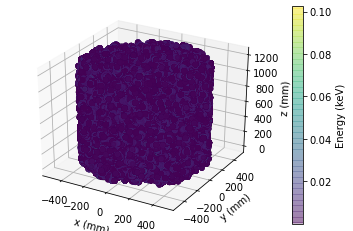

In [30]:
evt_hits = true_0nubb_hits[true_0nubb_hits.event_id == event]
evt_hits = true_0nubb_hits[true_0nubb_hits.label == 'ACTIVE']

xt = evt_hits.x
yt = evt_hits.y
zt = evt_hits.z
et = evt_hits.energy

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(xt, yt, zt, c=et, alpha=0.3, cmap='viridis')
cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

plt.show()

### Checking DECO tracks - FULLSIM - B-CUBIC

In [11]:
filepath = '/Users/halmamol/NEXT/files/NEXT100/beershebaFS/'

In [12]:
#0nubb files
deco_list_0nubb = []

filepath_0nubb_deco = filepath+f'0nubb/hits/'

filename_0nubb = filepath_0nubb_deco+f'next100.0nubb.1.deconv.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
try:
    readfile_deco = pd.read_hdf(filename_0nubb, 'DECO/Events')
except:
    print('File {} not good'.format(filename_0nubb))

deco_list_0nubb.append(readfile_deco)
filename_0nubb = filepath_0nubb_deco+f'next100.0nubb.2.deconv.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
try:
    readfile_deco = pd.read_hdf(filename_0nubb, 'DECO/Events')
except:
    print('File {} not good'.format(filename_0nubb))

deco_list_0nubb.append(readfile_deco)

deco_0nubb_FS_bc = pd.concat([dt for dt in deco_list_0nubb]) 
deco_0nubb_FS_bc.columns  

Index(['event', 'npeak', 'X', 'Y', 'Z', 'E'], dtype='object')

In [13]:
deco_0nubb_FS_bc_evt = deco_0nubb_FS_bc[deco_0nubb_FS_bc.event == event]

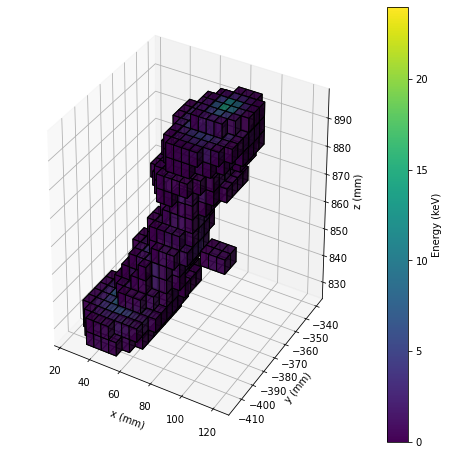

In [14]:
base_vsize = 5 #mm
the_hits = []

xs = deco_0nubb_FS_bc_evt.X
ys = deco_0nubb_FS_bc_evt.Y
zs = deco_0nubb_FS_bc_evt.Z
es = deco_0nubb_FS_bc_evt.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

plt.show()

### Retrieving RECO tracks - FULLSIM - B-CUBIC

In [15]:
filepath = '/Users/halmamol/NEXT/files/NEXT100/beershebaFS/'

In [16]:
#0nubb files
track_list_0nubb = []

filepath_0nubb_tracks = filepath+f'0nubb/tracks/{blobR}mm/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb = filepath_0nubb_tracks+f'next100.0nubb.{nfile}.skel_tracks.R{blobR}mm.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks = pd.read_hdf(filename_0nubb, 'Tracks')
    except:
        print('File {} not good'.format(filename_0nubb))
        continue
        
    track_list_0nubb.append(readfile_tracks)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_0nubb_FS_bc = pd.concat([dt for dt in track_list_0nubb]) 
tracks_0nubb_FS_bc.columns  

File /Users/halmamol/NEXT/files/NEXT100/beershebaFS/0nubb/tracks/21mm/next100.0nubb.723.skel_tracks.R21mm.h5 not good


Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

In [17]:
tracks_0nubb_FS_bc_evt = tracks_0nubb_FS_bc[(tracks_0nubb_FS_bc.event == event) & (tracks_0nubb_FS_bc.trackID == 0)]
tracks_0nubb_FS_bc_evt

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,6,0,2.474666,120.271862,705,25458,2,23.5,-413.5,825.21125,...,888.53699,34.888889,-379.0,831.376995,0.893941,0.536796,0,4.95,4.75,4.900092


In [18]:
tracks_0nubb_FS_bc_evt_blob1_x = float(tracks_0nubb_FS_bc_evt.blob1_x.values)
tracks_0nubb_FS_bc_evt_blob1_y = float(tracks_0nubb_FS_bc_evt.blob1_y.values)
tracks_0nubb_FS_bc_evt_blob1_z = float(tracks_0nubb_FS_bc_evt.blob1_z.values)
tracks_0nubb_FS_bc_evt_blob1_e = float(tracks_0nubb_FS_bc_evt.eblob1.values)

tracks_0nubb_FS_bc_evt_blob2_x = float(tracks_0nubb_FS_bc_evt.blob2_x.values)
tracks_0nubb_FS_bc_evt_blob2_y = float(tracks_0nubb_FS_bc_evt.blob2_y.values)
tracks_0nubb_FS_bc_evt_blob2_z = float(tracks_0nubb_FS_bc_evt.blob2_z.values)
tracks_0nubb_FS_bc_evt_blob2_e = float(tracks_0nubb_FS_bc_evt.eblob2.values)

### Checking DECO tracks - FULLSIM - B-NEAREST

In [19]:
filepath = '/Users/halmamol/NEXT/files/NEXT100/beershebaFS/'

In [20]:
#0nubb files
deco_list_0nubb = []

filepath_0nubb_deco = filepath+f'0nubb/hits/'

filename_0nubb = filepath_0nubb_deco+f'next100.0nubb.1.deconv_tb.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
try:
    readfile_deco = pd.read_hdf(filename_0nubb, 'DECO/Events')
except:
    print('File {} not good'.format(filename_0nubb))

deco_list_0nubb.append(readfile_deco)
filename_0nubb = filepath_0nubb_deco+f'next100.0nubb.2.deconv_tb.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
try:
    readfile_deco = pd.read_hdf(filename_0nubb, 'DECO/Events')
except:
    print('File {} not good'.format(filename_0nubb))

deco_list_0nubb.append(readfile_deco)

deco_0nubb_FS_bn = pd.concat([dt for dt in deco_list_0nubb]) 
deco_0nubb_FS_bn.columns
deco_0nubb_FS_bn

,event,npeak,X,Y,Z,E
0,0,0,-225.5,-242.5,310.205250,0.000027
1,0,0,-225.5,-241.5,310.205250,0.000028
2,0,0,-225.5,-240.5,310.205250,0.000029
3,0,0,-225.5,-239.5,310.205250,0.000029
4,0,0,-225.5,-238.5,310.205250,0.000029
...,...,...,...,...,...,...
283968,19,0,14.5,22.5,1076.769875,0.000032
283969,19,0,14.5,23.5,1076.769875,0.000032
283970,19,0,14.5,24.5,1076.769875,0.000032
283971,19,0,14.5,25.5,1076.769875,0.000030


In [21]:
deco_0nubb_FS_bn_evt = deco_0nubb_FS_bn[deco_0nubb_FS_bn.event == event]

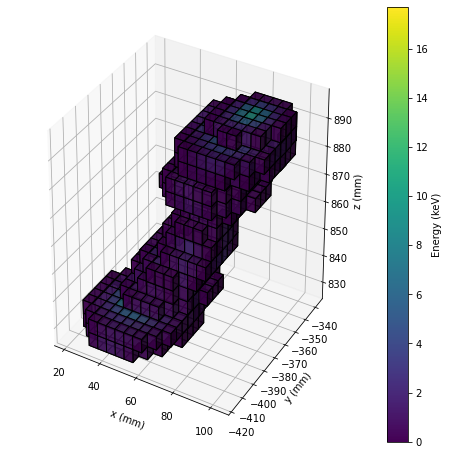

In [22]:
base_vsize = 5 #mm
the_hits = []

xs = deco_0nubb_FS_bn_evt.X
ys = deco_0nubb_FS_bn_evt.Y
zs = deco_0nubb_FS_bn_evt.Z
es = deco_0nubb_FS_bn_evt.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

plt.show()

### Retrieving RECO tracks - FULLSIM - B-NEAREST

In [23]:
filepath = '/Users/halmamol/NEXT/files/NEXT100/beershebaFS/'

In [24]:
#0nubb files
track_list_0nubb = []

filepath_0nubb_tracks = filepath+f'0nubb/tracks/{blobR}mm/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb = filepath_0nubb_tracks+f'next100.0nubb.{nfile}.skel_tracks.R{blobR}mm_tb.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks = pd.read_hdf(filename_0nubb, 'Tracks')
    except:
        print('File {} not good'.format(filename_0nubb))
        continue
        
    track_list_0nubb.append(readfile_tracks)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_0nubb_FS_bn = pd.concat([dt for dt in track_list_0nubb]) 
tracks_0nubb_FS_bn.columns  

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

In [25]:
tracks_0nubb_FS_bn_evt = tracks_0nubb_FS_bn[(tracks_0nubb_FS_bn.event == event) & (tracks_0nubb_FS_bn.trackID == 0)]
tracks_0nubb_FS_bn_evt

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,6,0,2.47725,124.884078,820,30546,1,20.5,-416.5,825.21125,...,888.53699,32.909091,-379.35,831.376995,0.882183,0.443271,0.0,4.882353,4.875,4.900092


In [26]:
tracks_0nubb_FS_bn_evt_blob1_x = float(tracks_0nubb_FS_bn_evt.blob1_x.values)
tracks_0nubb_FS_bn_evt_blob1_y = float(tracks_0nubb_FS_bn_evt.blob1_y.values)
tracks_0nubb_FS_bn_evt_blob1_z = float(tracks_0nubb_FS_bn_evt.blob1_z.values)
tracks_0nubb_FS_bn_evt_blob1_e = float(tracks_0nubb_FS_bn_evt.eblob1.values)

tracks_0nubb_FS_bn_evt_blob2_x = float(tracks_0nubb_FS_bn_evt.blob2_x.values)
tracks_0nubb_FS_bn_evt_blob2_y = float(tracks_0nubb_FS_bn_evt.blob2_y.values)
tracks_0nubb_FS_bn_evt_blob2_z = float(tracks_0nubb_FS_bn_evt.blob2_z.values)
tracks_0nubb_FS_bn_evt_blob2_e = float(tracks_0nubb_FS_bn_evt.eblob2.values)

## RESULTS

In [27]:
print('TRUE - PARTICLE 1')
print(f'(x,y,z) = ({true_0nubb_evt_part1_x},{true_0nubb_evt_part1_y},{true_0nubb_evt_part1_z})')
print(f'kin e = {true_0nubb_evt_part1_kinE}')
print('TRUE - PARTICLE 2')
print(f'(x,y,z) = ({true_0nubb_evt_part2_x},{true_0nubb_evt_part2_y},{true_0nubb_evt_part2_z})')
print(f'kin e = {true_0nubb_evt_part2_kinE}')

print('- B CUBIC - ')
print('RECO - BLOB 1')
print(f'(x,y,z) = ({tracks_0nubb_FS_bc_evt_blob1_x},{tracks_0nubb_FS_bc_evt_blob1_y},{tracks_0nubb_FS_bc_evt_blob1_z})')
print(f' e = {tracks_0nubb_FS_bc_evt_blob1_e}')
print('RECO - BLOB 2')
print(f'(x,y,z) = ({tracks_0nubb_FS_bc_evt_blob2_x},{tracks_0nubb_FS_bc_evt_blob2_y},{tracks_0nubb_FS_bc_evt_blob2_z})')
print(f' e = {tracks_0nubb_FS_bc_evt_blob2_e}')

print('- B NEAREST - ')
print('RECO - BLOB 1')
print(f'(x,y,z) = ({tracks_0nubb_FS_bn_evt_blob1_x},{tracks_0nubb_FS_bn_evt_blob1_y},{tracks_0nubb_FS_bn_evt_blob1_z})')
print(f' e = {tracks_0nubb_FS_bn_evt_blob1_e}')
print('RECO - BLOB 2')
print(f'(x,y,z) = ({tracks_0nubb_FS_bn_evt_blob2_x},{tracks_0nubb_FS_bn_evt_blob2_y},{tracks_0nubb_FS_bn_evt_blob2_z})')
print(f' e = {tracks_0nubb_FS_bn_evt_blob2_e}')

TRUE - PARTICLE 1
(x,y,z) = (79.52174377441406,-367.90618896484375,886.2837524414062)
kin e = 0.6220611929893494
TRUE - PARTICLE 2
(x,y,z) = (42.92877960205078,-392.05810546875,828.4129028320312)
kin e = 1.8357690572738647
- B CUBIC - 
RECO - BLOB 1
(x,y,z) = (82.66666666666717,-369.30769230769135,888.5369897836565)
 e = 0.8939408279348647
RECO - BLOB 2
(x,y,z) = (34.88888888888606,-379.0,831.3769945913434)
 e = 0.5367964476087693
- B NEAREST - 
RECO - BLOB 1
(x,y,z) = (81.09090909091182,-369.9499999999991,888.5369897836565)
 e = 0.8821833113647122
RECO - BLOB 2
(x,y,z) = (32.909090909088185,-379.3500000000003,831.3769945913434)
 e = 0.44327105098749203
